In [1]:
!python3 -V

Python 3.8.10


In [1]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import torch
from jax import random, grad, vmap, jit, hessian
from jax.experimental import optimizers
from jax.experimental.optimizers import adam, exponential_decay
from jax.experimental.ode import odeint
from jax.nn import relu, elu, softplus
from jax.config import config
from jax.ops import index_update, index
from jax import lax
from jax.lax import while_loop, scan, cond
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

import sys
sys.path.append('../DeepONetsPI/')  # add the pde package to the python path

from layers import MLP, modified_MLP, FF_MLP
from model import DeepONetPI
from utils import RBF
from DataGenerator import DataGenerator

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Diffusion Reaction Equation
$$
\frac{\partial s}{\partial t}=D \frac{\partial^{2} s}{\partial x^{2}}+k s^{2}+u(x), \quad x \in(0,1), t \in(0,1]
$$


# Define Network

In [2]:
class DRDeepONetPI(DeepONetPI):
    def __init__(self,
                 branch_layers, 
                 trunk_layers, 
                 branch_net=MLP,
                 trunk_net=MLP,
                 branch_activation=jnp.tanh,
                 trunk_activation=jnp.tanh,
                 branch_rng_key=random.PRNGKey(1234),
                 trunk_rng_key=random.PRNGKey(4321),
                 optimizer=adam(exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)),
                 operator_loss_const=1.0,
                 physics_loss_const=1.0,
                 bcs_loss_const=1.0,
                 ics_loss_const=1.0,
                 ckpt_dir='DiffusionReaction',
                 ckpt_file='params.npy',
                 loss_file='loss.npy',
                 loss_operator_file='loss_operator.npy',
                 loss_physics_file='loss_physics.npy',
                 loss_bcs_file='loss_bcs.npy',
                 loss_ics_file='loss_ics.npy',   
                 ):
        super().__init__(branch_layers, 
                         trunk_layers, 
                         branch_net, 
                         trunk_net, 
                         branch_activation, 
                         trunk_activation, 
                         branch_rng_key, 
                         trunk_rng_key, 
                         optimizer, 
                         operator_loss_const, 
                         physics_loss_const, 
                         bcs_loss_const, 
                         ics_loss_const, 
                         ckpt_dir, 
                         ckpt_file, 
                         loss_file, 
                         loss_operator_file, 
                         loss_physics_file, 
                         loss_bcs_file, 
                         loss_ics_file)
        
    def pde_net(self, params, u, y):
        # note that y here can include additional coord not passed to the original operator network
        # print(y.shape)
        x = y[0]
        t = y[1]
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, x, t) # actual value of s (may not be needed)
        s_x = grad(s_, 2)(params, u, x, t) 
        s_t = grad(s_, 3)(params, u, x, t)
        s_xx = grad(grad(s_, 2), 2)(params, u, x, t)
        res = s_t - 0.01 * s_xx - 0.01 * s**2 # this is equal to u(x), this avoids the interpolation
        return res
    
    # here we are provided with values for BC/IC (zero), so for this case just call the operator net.  If we had Robin BC for example, we would output an array with outputs of [value, derivative]
    # Also, if we had the case where BC/IC = u, we would return res = s - u
    def bc_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, y) # actual value of s
        return s
    
    def ic_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, y) # actual value of s
        return s


# Generate Data functions

In [3]:
# Use double precision to generate data (due to GP sampling)

# A diffusion-reaction numerical solver
def solve_ADR(key, Nx, Nt, N_op, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*jnp.ones_like(x)
    v = lambda x: jnp.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: jnp.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = jnp.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = jnp.linalg.cholesky(K + jitter*jnp.eye(N))
    gp_sample = jnp.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: jnp.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = jnp.linspace(xmin, xmax, Nx)
    t = jnp.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = jnp.eye(Nx, k=1) - jnp.eye(Nx, k=-1)
    D2 = -2 * jnp.eye(Nx) + jnp.eye(Nx, k=-1) + jnp.eye(Nx, k=1)
    D3 = jnp.eye(Nx - 2)
    M = -jnp.diag(D1 @ k) @ D1 - 4 * jnp.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * jnp.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * jnp.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = jnp.zeros((Nx, Nt))
    # u = index_update(u, index[:,0], u0(x)) # this index_update syntax has been decapitated and the new syntax is better
    u = u.at[:, 0].set(u0(x))
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = jnp.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        # u = index_update(u, index[1:-1, i + 1], jnp.linalg.solve(A, b1 + b2)) # this index_update syntax has been decapitated and the new syntax is better
        u = u.at[1:-1, i + 1].set(jnp.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    S = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    xx = jnp.linspace(xmin, xmax, m)
    u = f_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(subkeys[1], (N_op, 2), 0, max(Nx,Nt))
    y = jnp.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = S[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, S), (u, y, s)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, N_op, N_pde, N_bcs, N_ics):
    # Numerical solution
    (x, t, S), (u, y, s) = solve_ADR(key, Nx , Nt, N_op, length_scale)

    # Geneate subkeys
    subkeys = random.split(key, 4)
    
    # Sample the data
    u_op = jnp.tile(u, (N_op, 1))
    y_op = y
    s_op = s
    
    # Generate data for PDE constraints
    # Sample collocation points
    # Chooses N_pde random points in domain of (x, t).  We don't need to have a correct prediction for solution s, only that our prediction by the ANN satisfies the pde at the specified (x,t). For s, we take set s(x) = u(x) assuming that u is defined at each coordinate x (guarenteed in solve_ADR).
    x_pde_idx = random.choice(subkeys[0], jnp.arange(Nx), shape=(N_pde,1))
    x_pde = x[x_pde_idx]
    t_pde = random.uniform(subkeys[1], minval=0, maxval=1, shape=(N_pde,1))

    u_pde = jnp.tile(u, (N_pde, 1))
    y_pde = jnp.hstack((x_pde, t_pde))
    s_pde = u[x_pde_idx]
    
    # Sample points from the boundary conditions
    # handle odd number of bc
    N_bc_half1 = N_bcs // 2
    N_bc_half2 = N_bcs - N_bc_half1
    x_bc1 = jnp.zeros((N_bc_half1, 1))
    x_bc2 = jnp.ones((N_bc_half2, 1))
    x_bcs = jnp.vstack((x_bc1, x_bc2))
    t_bcs = random.uniform(subkeys[2], shape=(N_bcs, 1))
    
    u_bcs = jnp.tile(u, (N_bcs, 1))
    y_bcs = jnp.hstack([x_bcs, t_bcs])
    s_bcs = jnp.zeros((N_bcs, 1))
    
    # Sample points from initial conditions
    x_ics = random.uniform(subkeys[3], shape=(N_ics, 1))
    t_ics = jnp.zeros((N_ics, 1))

    u_ics = jnp.tile(u, (N_ics, 1))
    y_ics = jnp.hstack([x_ics, t_ics])
    s_ics = jnp.zeros((N_ics, 1))
    
    
    # Shorthand tuples to pass fewer outputs
    train_op = (u_op, y_op, s_op)
    train_pde = (u_pde, y_pde, s_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs)
    train_ics = (u_ics, y_ics, s_ics)
    

    return train_op, train_pde, train_bcs, train_ics

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, N_op):
    Nx = N_op
    Nt = N_op
    (x, t, S), (u, y, s) = solve_ADR(key, Nx , Nt, N_op, length_scale)

    XX, TT = jnp.meshgrid(x, t)

    u_test = jnp.tile(u, (N_op**2,1))
    y_test = jnp.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = S.T.flatten()

    return u_test, y_test, s_test

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, N_op, N_pde, N_ics, N_bcs):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    train_op, train_pde, train_bcs, train_ics = vmap(generate_one_training_data, (0, None, None, None, None))(keys, N_op, N_pde, N_bcs, N_ics)
    
    u_op, y_op, s_op = train_op
    u_pde, y_pde, s_pde = train_pde
    u_bcs, y_bcs, s_bcs = train_bcs
    u_ics, y_ics, s_ics = train_ics

    u_op = jnp.float32(u_op.reshape(N * N_op,-1))
    y_op = jnp.float32(y_op.reshape(N * N_op,-1))
    s_op = jnp.float32(s_op.reshape(N * N_op,-1))

    u_pde = jnp.float32(u_pde.reshape(N * N_pde,-1))
    y_pde = jnp.float32(y_pde.reshape(N * N_pde,-1))
    s_pde = jnp.float32(s_pde.reshape(N * N_pde,-1))

    u_bcs = jnp.float32(u_bcs.reshape(N * N_bcs,-1))
    y_bcs = jnp.float32(y_bcs.reshape(N * N_bcs,-1))
    s_bcs = jnp.float32(s_bcs.reshape(N * N_bcs,-1))

    u_ics = jnp.float32(u_ics.reshape(N * N_ics,-1))
    y_ics = jnp.float32(y_ics.reshape(N * N_ics,-1))
    s_ics = jnp.float32(s_ics.reshape(N * N_ics,-1))
    
    config.update("jax_enable_x64", False)
    
    # Shorthand tuples to pass fewer outputs
    train_op = (u_op, y_op, s_op)
    train_pde = (u_pde, y_pde, s_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs)
    train_ics = (u_ics, y_ics, s_ics)


    return train_op, train_pde, train_bcs, train_ics

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, N_op):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, N_op)

    u_test = jnp.float32(u_test.reshape(N * N_op**2,-1))
    y_test = jnp.float32(y_test.reshape(N * N_op**2,-1))
    s_test = jnp.float32(s_test.reshape(N * N_op**2,-1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test

# Compute relative l2 error over N_op test samples.
def compute_error(key, N_op):
    # Generate one test sample
    u_test, y_test, s_test = generate_test_data(key, 1, N_op)
    # Predict  
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    # Compute relative l2 error
    error_s = jnp.linalg.norm(s_test - s_pred) / jnp.linalg.norm(s_test) 
    return error_s


# Define Dataset Parameters

In [4]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 5000 # number of input samples (different u values)
m = Nx   # number of input sensors
N_op_train = 100 # number data outputs per sample 
N_pde_train = 100  # number of points for PDE constrains pe sample
N_bcs_train = 100 # number of BC points 
N_ics_train = 100 # number of IC points

# Generate the data

In [6]:
train_op, train_pde, train_bcs, train_ics = generate_training_data(key, N, N_op_train, N_pde_train, N_bcs_train, N_ics_train)

u_op, y_op, s_op = train_op
u_pde, y_pde, s_pde = train_pde
u_bcs, y_bcs, s_bcs = train_bcs
u_ics, y_ics, s_ics = train_ics

RuntimeError: jaxlib/cusolver.cc:52: operation cusolverDnCreate(&handle) failed: cuSolver internal error

# Initialize model

In [ ]:
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = DRDeepONetPI(branch_layers, trunk_layers, branch_net=modified_MLP, trunk_net=modified_MLP)

# Restore the model

In [7]:
model.restore()
model.restore_history()
model.loss_log

[1.9921083,
 0.79662216,
 0.6228643,
 0.55730116,
 0.53510803,
 0.52450705,
 0.5004971,
 0.4884455,
 0.48285872,
 0.47015277,
 0.45022106,
 0.43433353,
 0.4081164,
 0.40623224,
 0.39857614,
 0.38611174,
 0.3789066,
 0.3807477,
 0.3748141,
 0.36271536,
 0.35367972,
 0.35672954,
 0.35431412,
 0.33037654,
 0.3262705,
 0.32086954,
 0.3071424,
 0.30347785,
 0.29867247,
 0.29745597,
 0.29397124,
 0.28506765,
 0.28517613,
 0.28192043,
 0.27745974,
 0.28084868,
 0.2688957,
 0.26763618,
 0.2611838,
 0.2552518,
 0.25441596,
 0.24925672,
 0.23781192,
 0.2433524,
 0.24092887,
 0.23734786,
 0.23062086,
 0.23193875,
 0.23057064,
 0.22919162,
 0.23007016,
 0.22076645,
 0.22348583,
 0.22527727,
 0.22577071,
 0.21782616,
 0.21970445,
 0.21421759,
 0.21639335,
 0.21853468,
 0.21223919,
 0.2139521,
 0.2128844,
 0.20962338,
 0.21524046,
 0.20916577,
 0.21323657,
 0.2054545,
 0.20765802,
 0.20885819,
 0.20681739,
 0.20463228,
 0.20154431,
 0.20459412,
 0.20635541,
 0.19727299,
 0.19966544,
 0.19721395,
 0.

# Create data set

In [9]:
batch_size = 10000
op_dataset = DataGenerator(u_op, y_op, s_op, batch_size)
pde_dataset = DataGenerator(u_pde, y_pde, s_pde, batch_size)
bcs_dataset = DataGenerator(u_bcs, y_bcs, s_bcs, batch_size)
ics_dataset = DataGenerator(u_ics, y_ics, s_ics, batch_size)

# Train

In [10]:
model.train(op_dataset, pde_dataset, bcs_dataset, ics_dataset, nIter=100000)

 89%|████████▉ | 89040/100000 [1:41:49<12:32, 14.57it/s, loss=2.1091348e-05, loss_operator=1.0353403e-06, loss_physics=1.4689156e-05, loss_bcs=2.738658e-06, loss_ics=2.6281948e-06]   


KeyboardInterrupt: 

# Save the Network

In [11]:
model.save()
model.save_history()

In [61]:
# ckpt_dir = 'DiffusionReaction'
# ckpt_file = 'params.npy'
# loss_file = 'loss.npy'
# loss_operator_file = 'loss_operator.npy'
# loss_physics_file = 'loss_physics.npy'
# loss_bcs_file = 'loss_bcs.npy'
# loss_ics_file = 'loss_ics.npy'

# os.makedirs(ckpt_dir, exist_ok=True)
# ckpt_path = os.path.join(ckpt_dir, ckpt_file)
# loss_path = os.path.join(ckpt_dir, loss_file)
# loss_operator_path = os.path.join(ckpt_dir, loss_operator_file)
# loss_physics_path = os.path.join(ckpt_dir, loss_physics_file)
# loss_bcs_path = os.path.join(ckpt_dir, loss_bcs_file)
# loss_ics_path = os.path.join(ckpt_dir, loss_ics_file)

# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# jnp.save(ckpt_path, flat_params)
# jnp.save(loss_path, model.loss_log)
# jnp.save(loss_operator_path, model.loss_operator_log)
# jnp.save(loss_physics_path, model.loss_physics_log)
# jnp.save(loss_bcs_path, model.loss_bcs_log)
# jnp.save(loss_ics_path, model.loss_ics_log)


# Restore the Network

In [12]:
flat_params = jnp.load(ckpt_path)
params = model.unravel_params(flat_params)

loss_operator_log = jnp.load(loss_operator_path)
loss_physics_log = jnp.load(loss_physics_path)
loss_bcs_log = jnp.load(loss_bcs_path)
loss_ics_log = jnp.load(loss_ics_path)


NameError: name 'ckpt_path' is not defined

# Test if params updats a new network

In [74]:
new_model = DRDeepONetPI(branch_layers, trunk_layers)
new_params = new_model.unravel_params(flat_params)
new_opt_state = new_model.opt_init(new_params)
new_model.get_params(new_opt_state)



([(DeviceArray([[-0.02464836, -0.07107443,  0.00974863, ...,  0.03385358,
                  0.03254217, -0.03090487],
                [-0.09536412, -0.13050005, -0.03608083, ..., -0.16176127,
                 -0.05601719, -0.04893256],
                [ 0.10658715, -0.09364573, -0.13595116, ...,  0.07952645,
                  0.02991575, -0.00303205],
                ...,
                [ 0.07826772, -0.06614865, -0.09580293, ..., -0.03131206,
                 -0.09020152, -0.00609101],
                [ 0.07959943, -0.17555547, -0.01170371, ...,  0.01066105,
                 -0.11537156,  0.05821477],
                [-0.01774321,  0.07871401,  0.12899522, ...,  0.06831719,
                 -0.14896844,  0.01428811]], dtype=float32),
   DeviceArray([ 0.03955923, -0.02542204, -0.07117924,  0.01791051,
                -0.02099251, -0.00266437,  0.00193929,  0.00514002,
                 0.00486573, -0.03417101, -0.0034874 ,  0.03895249,
                 0.09007668, -0.00488469, -0.00103

# Generate and Evaluate Test data

In [14]:
# Define number of samples and RNG
N_test = 100 # number of input samples 
m_test = m   # number of sensors 
key_test = random.PRNGKey(1234567)
keys_test = random.split(key_test, N_test)

# Predict
params = model.get_params(model.opt_state)

# Compute error
error_s = vmap(compute_error, (0, None))(keys_test, m_test) 
print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))


mean of relative L2 error of s: 2.90e-03
std of relative L2 error of s: 1.30e-03


# Plot for loss function

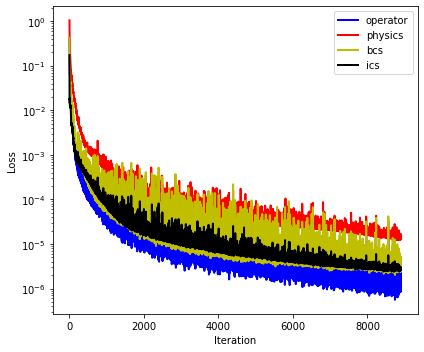

In [15]:
plt.figure(figsize = (6,5))
plt.plot(model.loss_operator_log, 'b-', lw=2, label='operator')
plt.plot(model.loss_physics_log, 'r-', lw=2, label='physics')
plt.plot(model.loss_bcs_log, 'y-', lw=2, label='bcs')
plt.plot(model.loss_ics_log, 'k-', lw=2, label='ics')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Generate one test sample

In [22]:
# key = random.PRNGKey(12345)
key = random.PRNGKey(112312347)
P_test = 100
Nx = m
u_test, y_test, s_test = generate_test_data(key, 1, P_test)

In [23]:
# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = jnp.linspace(0, 1, Nx)
t = jnp.linspace(0, 1, Nt)
XX, TT = jnp.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = jnp.linalg.norm(S_pred - S_test, 2) / jnp.linalg.norm(S_test, 2) 
print('Relative l2 errpr: {:.3e}'.format(error))

Relative l2 errpr: 1.590e-03


# Plot Predictions and True Values

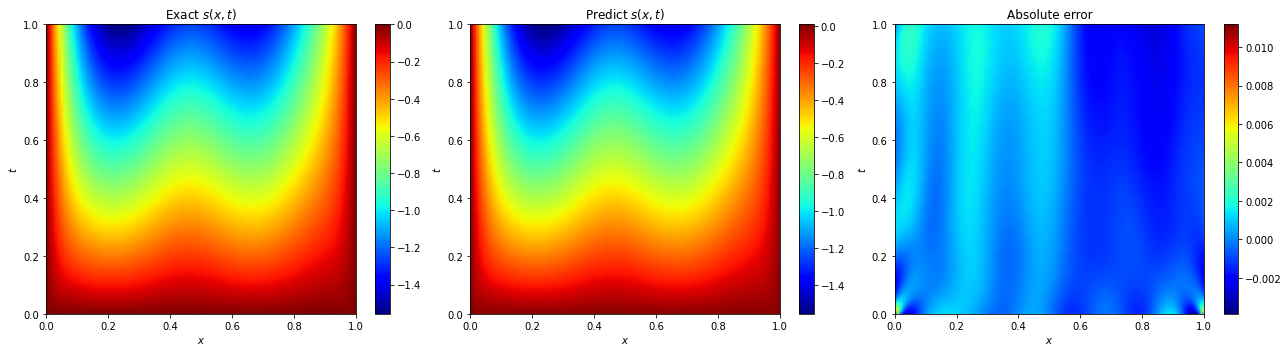

In [24]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(XX,TT, S_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_pred - S_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()